# Proyek Klasifikasi Gambar: Shoe_Sandal_Boot_Dataset
- **Nama:** Asgarindo Dwiki Ibrahim Adji
- **Email:** asgarindo9@gmail.com
- **ID Dicoding:** Asgarindo Dwiki Ibrahim Adji

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Data Preparation

In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

### Data Loading

In [3]:
dataset_dir = "Shoe vs Sandal vs Boot Dataset"

categories = ["Boot", "Sandal", "Shoe"]

filenames = []
category_labels = []

for category in categories:
    category_folder = os.path.join(dataset_dir, category)
    category_filenames = os.listdir(category_folder)

    for filename in category_filenames:
        filenames.append(filename)
        category_labels.append(category)


df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

df.head()

,filename,category
0,boot (4578).jpg,Boot
1,boot (2843).jpg,Boot
2,boot (2964).jpg,Boot
3,boot (1371).jpg,Boot
4,boot (2967).jpg,Boot


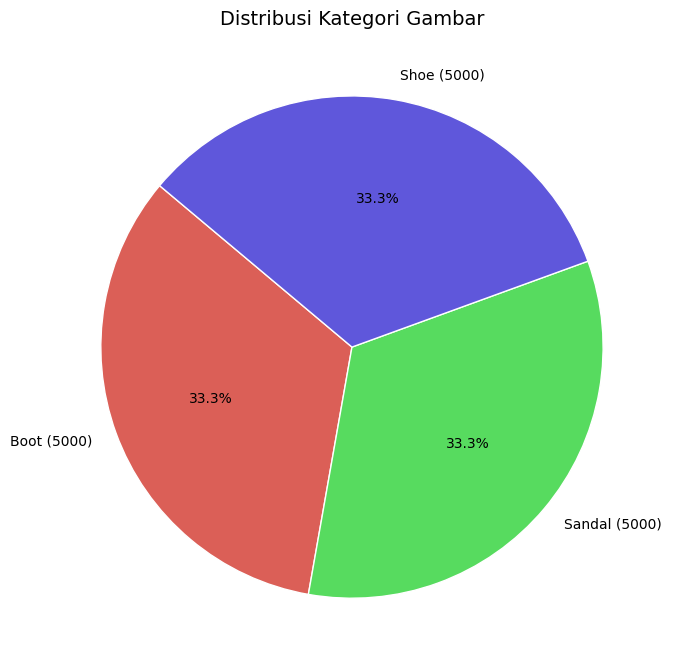

In [4]:
count = df['category'].value_counts()

colors = sns.color_palette("hls", len(count))
plt.figure(figsize=(7, 7), facecolor='white')
plt.pie(
    count,
    labels=[f'{label} ({value})' for label, value in zip(count.index, count.values)],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Distribusi Kategori Gambar', fontsize=14)
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [5]:
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['category'], random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 9000
Validation: 3000
Test: 3000


#### Make Directory

In [6]:
output_dir = 'Shoe_Sandal_Boot_Split'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for set_name in ['train', 'val', 'test']:
    set_path = os.path.join(output_dir, set_name)
    if not os.path.exists(set_path):
        os.makedirs(set_path)

    for category in ['Boot', 'Sandal', 'Shoe']:
        category_path = os.path.join(set_path, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)

train_df['set'] = 'train'
val_df['set'] = 'val'
test_df['set'] = 'test'

df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)

def copy_images(df, dataset_dir, output_dir):
    for index, row in df.iterrows():
        image_path = os.path.join(dataset_dir, row['category'], row['filename'])
        if not os.path.exists(image_path):
            print(f"File {image_path} tidak ditemukan.")
            continue

        destination_dir = os.path.join(output_dir, row['set'], row['category'])
        destination_file = os.path.join(destination_dir, row['filename'])
        if not os.path.exists(destination_file):
            shutil.copy(image_path, destination_file)

copy_images(df_all[df_all['set'] == 'train'], dataset_dir, output_dir)
copy_images(df_all[df_all['set'] == 'val'], dataset_dir, output_dir)
copy_images(df_all[df_all['set'] == 'test'], dataset_dir, output_dir)
print("Dataset dibagi")

Dataset dibagi


In [7]:
train_dir = 'Shoe_Sandal_Boot_Split/train'
val_dir = 'Shoe_Sandal_Boot_Split/val'
test_dir = 'Shoe_Sandal_Boot_Split/test'

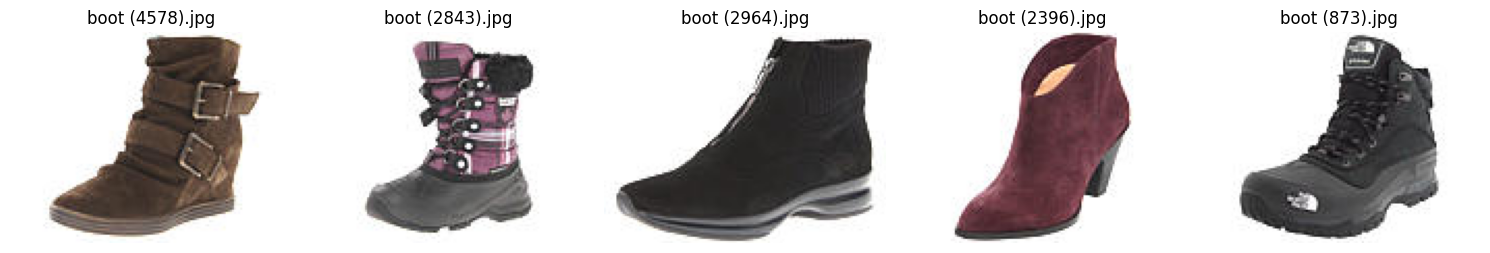

In [8]:
def visualize_images(path, num_images=5):
    image_filenames = os.listdir(path)
    num_images = min(num_images, len(image_filenames))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)

    plt.tight_layout()
    plt.show()

path_to_visualize = "Shoe_Sandal_Boot_Split/train/Boot"
visualize_images(path_to_visualize, num_images=5)

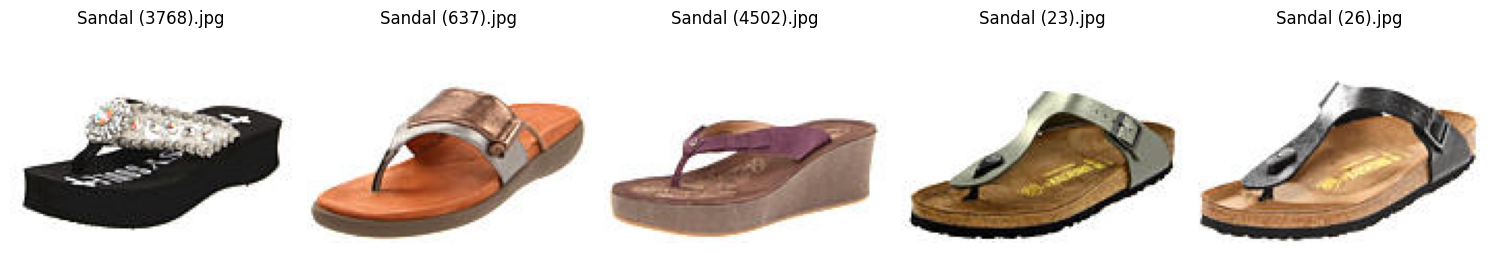

In [9]:
path_to_visualize = "Shoe_Sandal_Boot_Split/train/Sandal"
visualize_images(path_to_visualize, num_images=5)

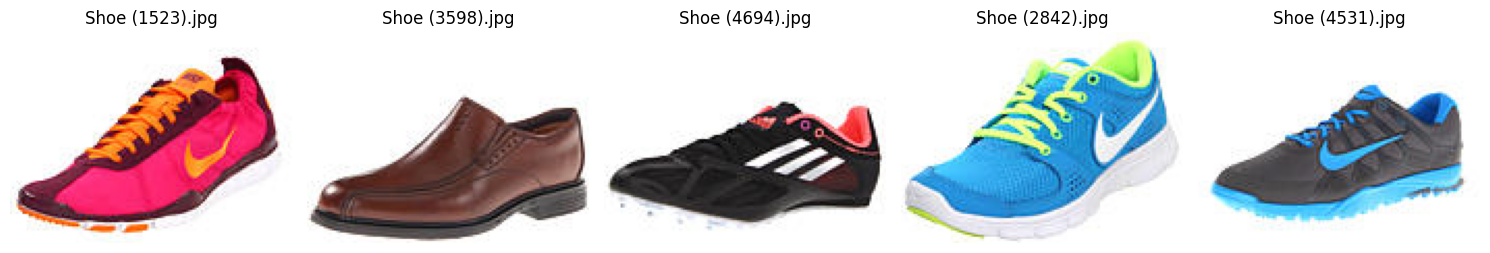

In [10]:
path_to_visualize = "Shoe_Sandal_Boot_Split/test/Shoe"
visualize_images(path_to_visualize, num_images=5)

#### Image Data Generator

In [11]:
batch_size = 32
image_size = (128, 128)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        )

validation_ds = val_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        )

test_ds = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        )

Found 9000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [12]:
print(f"Kelas yang ada: {train_ds.class_indices}")

Kelas yang ada: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}


## Modelling

In [13]:
model = Sequential(name='baimm_CNN_model')

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same', name='convlayer1'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='convlayer2'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='convlayer3'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', name='fully_connected'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax', name='outputlayer'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "baimm_CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convlayer1 (Conv2D)             │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convlayer2 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convlayer3 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected (Dense)         │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputlayer (Dense)             │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,963 (16.36 MB)

 Trainable params: 4,288,515 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### Compile

In [14]:
model.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

#### Fitting

In [15]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

history = model.fit(train_ds,
                        epochs= 30,
                        steps_per_epoch = len(train_ds),
                        validation_data = validation_ds,
                        validation_steps = len(validation_ds),
                        callbacks = early_stopping)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


282/282 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.7699 - loss: 1.3491 - val_accuracy: 0.5030 - val_loss: 1.7343
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8859 - loss: 0.3204 - val_accuracy: 0.9220 - val_loss: 0.2369
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9251 - loss: 0.2271 - val_accuracy: 0.9150 - val_loss: 0.5267
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9436 - loss: 0.1619 - val_accuracy: 0.9363 - val_loss: 0.1831
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9515 - loss: 0.1395 - val_accuracy: 0.9663 - val_loss: 0.1160
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9599 - loss: 0.1107 - val_accuracy: 0.9107 - val_loss: 0.3432
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9638 - loss: 0.0986 - val_accuracy: 0.8773 - val_loss: 1.2568
Epoch 8/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9721 - loss: 0.0788 - val_accuracy:

## Evaluasi dan Visualisasi

In [16]:
print("training loss: ", history.history['loss'][-1])
print("accuracy: ", history.history['accuracy'][-1])

training loss:  0.07738518714904785
accuracy:  0.9738888740539551


In [17]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9801 - loss: 0.0684
Validation Loss: 0.11598729342222214
Validation Accuracy: 0.9663333296775818


In [18]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9785 - loss: 0.0735
Test Loss: 0.13822373747825623
Test Accuracy: 0.9620000123977661


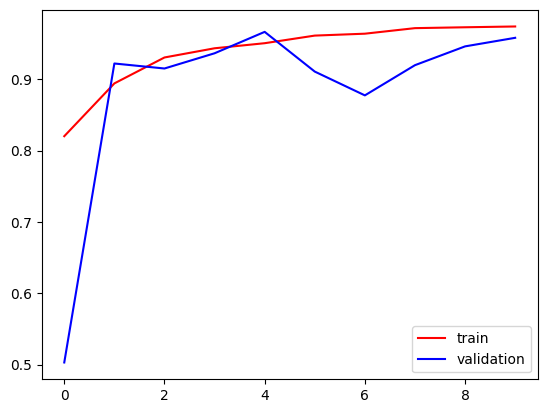

In [19]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

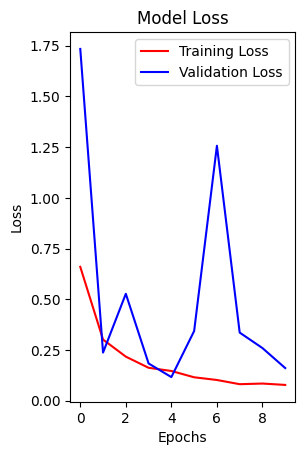

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='red', label='Training Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Konversi Model

In [21]:
import pathlib
os.mkdir("model_save")

export_dir = 'model_save/'
tf.saved_model.save(model, export_dir)

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.experimental_enable_resource_variables = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

os.makedirs("tflite", exist_ok=True)
tflite_model_file = pathlib.Path('tflite/model.tflite')
tflite_model_file.write_bytes(tflite_model)

16896

In [23]:
labels = list(train_ds.class_indices.keys())

with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

In [24]:
os.system("pip install tensorflowjs")
os.makedirs("tfjs_model", exist_ok=True)
os.system("tensorflowjs_converter --input_format=tf_saved_model model_save tfjs_model")

0

## Inference (Optional)

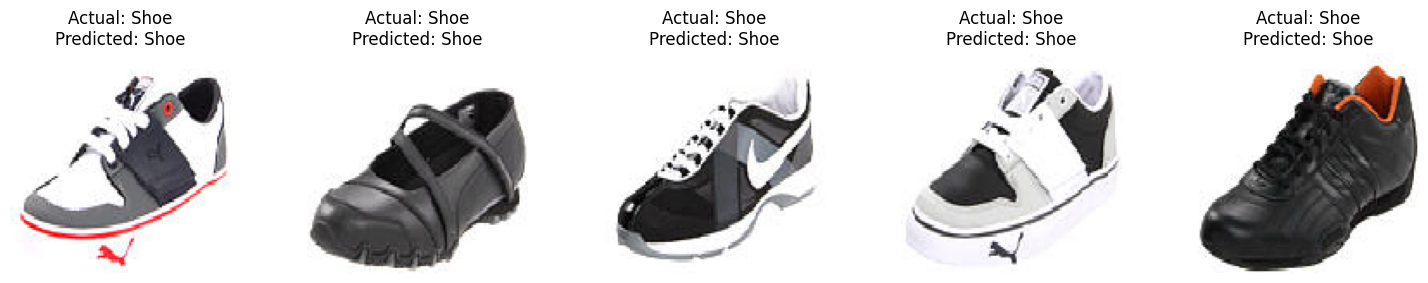

In [44]:
import random

model = tf.saved_model.load("model_save")
infer = model.signatures["serving_default"]

test_dir = "Shoe_Sandal_Boot_Split/test"
class_labels = list(sorted(next(os.walk(test_dir))[1]))

selected_class = "Shoe"
class_folder = os.path.join(test_dir, selected_class)

image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png'))]
random.shuffle(image_files)

num_images = 5
plt.figure(figsize=(15, 10))

for image_count, image_name in enumerate(image_files[:num_images]):
    image_path = os.path.join(class_folder, image_name)
    image = load_img(image_path, target_size=(128, 128))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)

    predictions = infer(tf.convert_to_tensor(image_array))
    predicted_class = class_labels[np.argmax(predictions["output_0"].numpy())]

    plt.subplot(4, 5, image_count + 1)
    plt.imshow(image)
    plt.title(f'Actual: {selected_class}\nPredicted: {predicted_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()